In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image
path = ['./images/pip00.png','./images/genai_plc.png','./images/fine-tune-img-1.png', './images/capability.png']


# Purpose

The Purpose of this notebook is to serve as a partial requirement for an employee evaluation plan.  I am to demonstrate the ability to code and to demonstrate to a committee that I can provide enough value to ericsson to justify my compensation.  I am to be guided in this endeavour by Manager Joji. 
This notebook is simply an inital milestone.

# Business Problem 

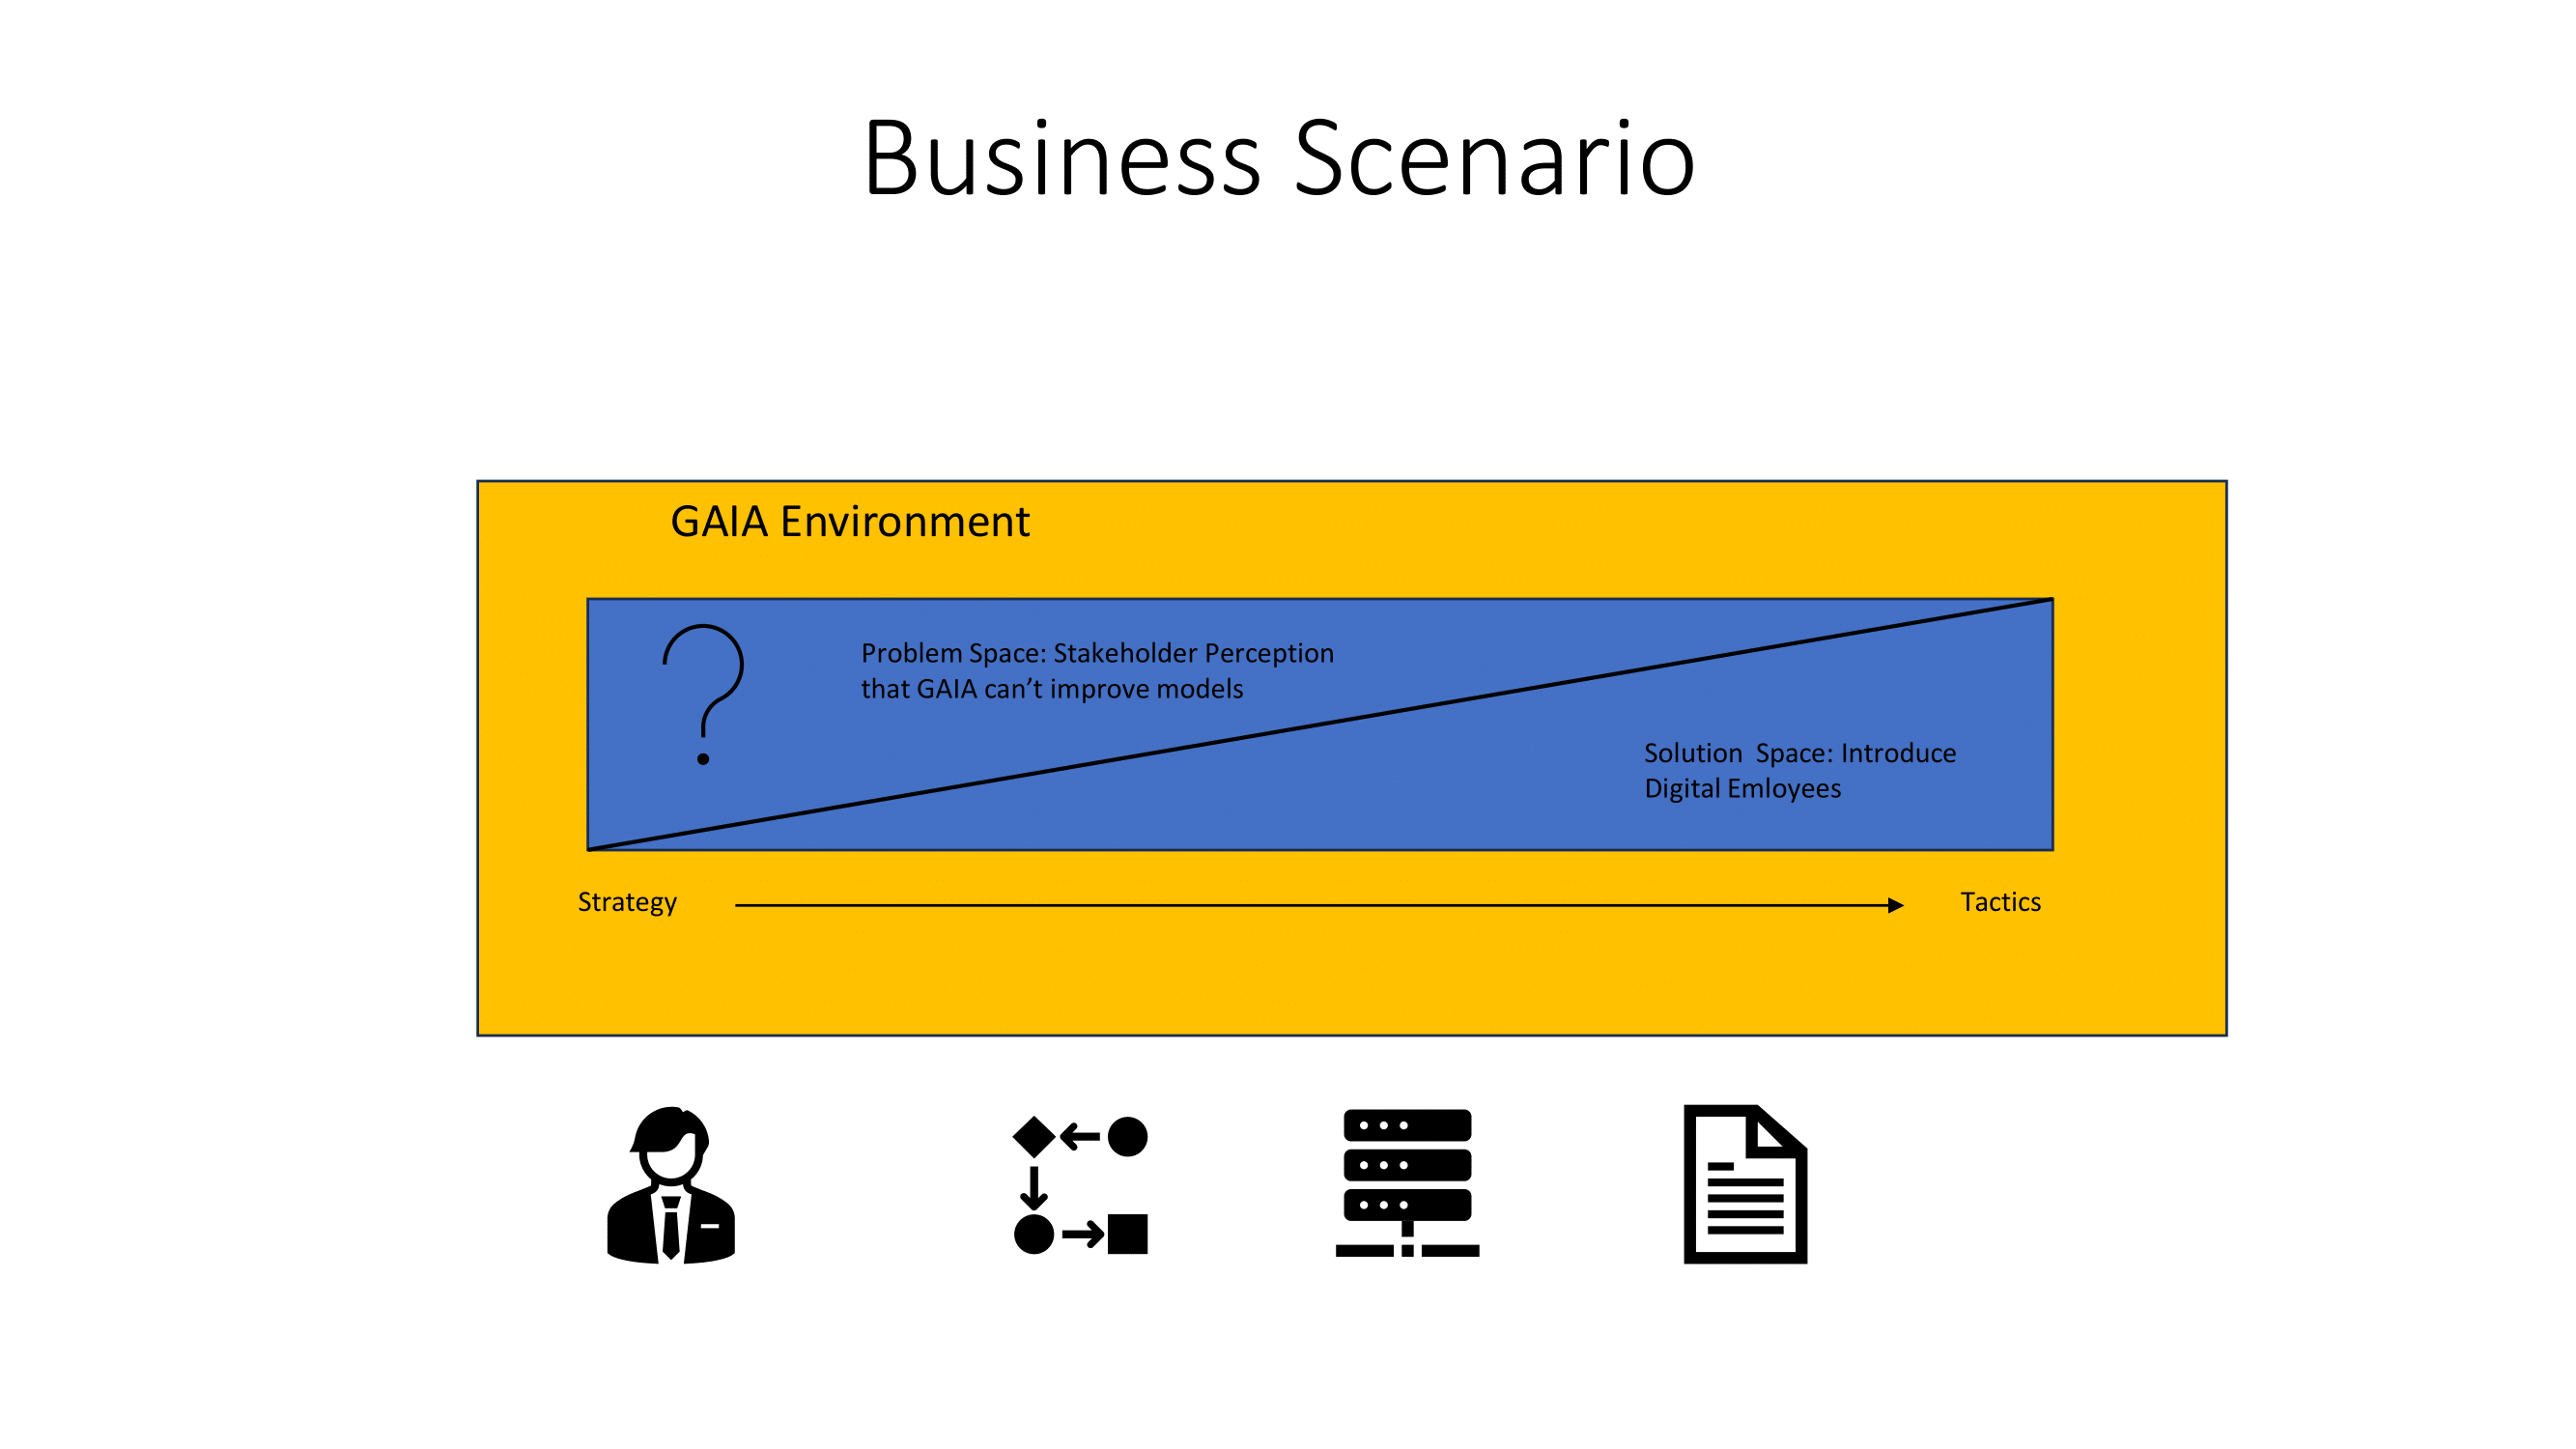

In [3]:
Image(path[0], width=800, height=800)

## Problem Space

The Business Problem/Driver is customer cmplaints that GAIA developers lack the capability to improve models. So this is the issue that we wish to address. This Business Scenario provides the context in which I attempt to show my value add.

Currently GAIA is project driven using the F-gate process. We will further refine the F-gate process with industry standard processes taken from Amazon and Deepmind for AI projects. Please see the following diagram. 

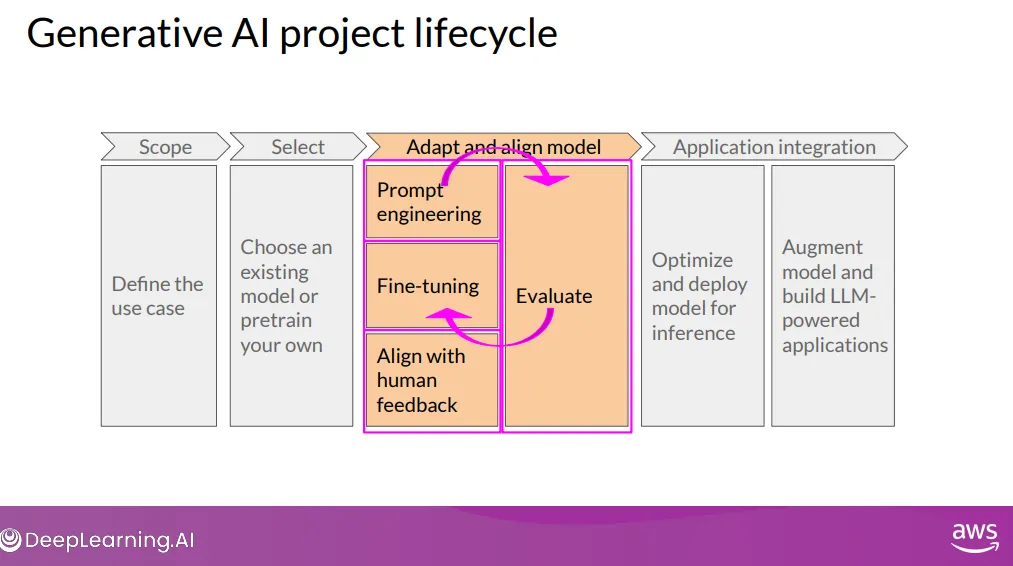

In [4]:
Image(path[1])

## Solution Space

We start with the business domain, in the Problem Space and we attempt to move to the Solution Space by adding **business capabilites**. 


A business capability has the model depicted below:

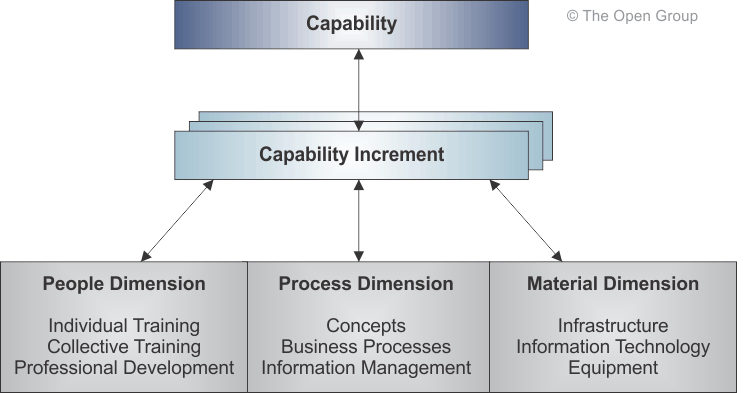

In [5]:
Image(path[3],  width =550, height =550)

### Proposed Capability Map with sub capabilities

**Digital Workforce Management**
- Design
- Create
- Lifecycle Management
- Retire
- Interface Management (with other Employees e.g. part of a Working Group)

The solution presented here is to augment the Human workforce with a Digital workforce. This Digital Workforce will **assist** the Human workforce with optimizing and improving models. 
Here is an example of a Team of Agents that could comprise a **Adapt and Align Team**. *I will carry out the tasks manually in  this notebook, since part of this exercise is to show that I can carry out these basic MLOPS tasks manually.*

**Adapt and Align Team** for GAIA Project 104 YourFavoriteProject

 1.  Prompt Engineering or ICL (In contect Learning)
 2.  Fine-Tuning Engineer
 3.  Alignment Engineer
 4.  Evaluation Engineer
 7.  Adapt and Align Coordinator/Stratetist  

# Case Study

## Statement 0f Work 

We assume the following:

 
- Use Case = ???, 
- Model = Flan-T5-base, 
- Task = dialogue summarization, 
- Metric = ROUGE metric 

The work focuses on **Adapt and Align** section of the GenAI lifecycle. We provide a basic demonstration of improving the Model on the Task using the Metric. The improvement work will includework Prompt Engineering, Finetuning , Alignment with human Feedback and Evaluation.

Deliverable is an **improved model**.

## Stategy

### Landscape of LLM Application Model Refinement as of date 2023 

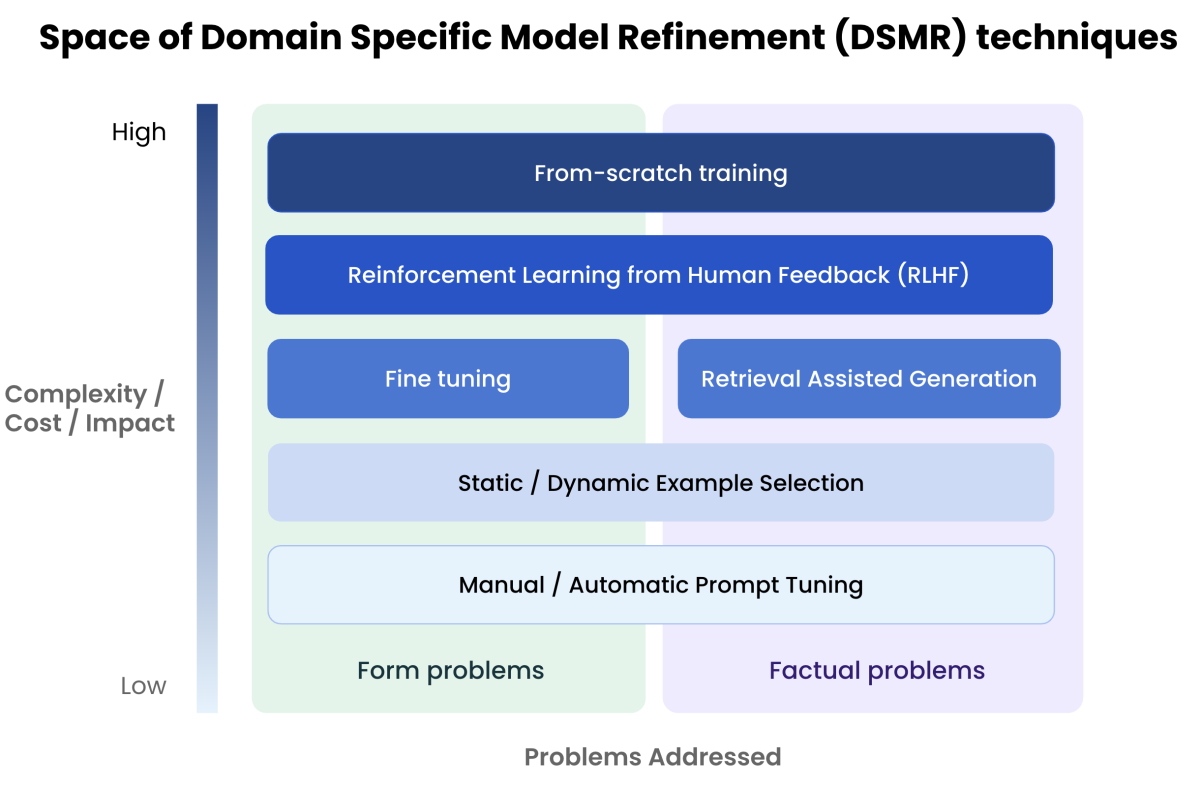

In [6]:
Image(path[2], width=800, height=600)

For the purposes of this notebook, the above diagram will serve as an example input to the Strategist. It represents a Refinement Landscape. Horizontally we have **Quality** and vertically we have **Performance**. 
Quality is further broken down into *form* (the style of the responses from an LLM) and *facts* refers to factually incorrect or irrelevant responses. **check into fathfulness, etc**
 
For this report let's assume that the customer complaints are categorized as **Quality** issues and furthermore as **form** or **style** problems.  (We will deal with fact or Knowledge Grounding in the next milestone notebook)

According to the refinement landscape, this is a prompt engineering or fine-tuning problem. 

## Environment Setup

### Software

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import torch
import evaluate
import time
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import (AutoModelForSeq2SeqLM, AutoModelForCausalLM, 
                          AutoTokenizer, GenerationConfig, TrainingArguments, Trainer)
from transformers import AutoTokenizer
from transformers import GenerationConfig

### Hardware 

In [9]:
# setting device on GPU if available, else CPU
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch_device)
print()


#Additional Info when using cuda
if torch_device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cpu



## Load Data and Model and Tokenizer

In [10]:
HUGGING_FACE_DATASET_NAME= "knkarthick/dialogsum"
DATASET= load_dataset(HUGGING_FACE_DATASET_NAME)

MODEL_NAME= 'google/flan-t5-base'
MODEL = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [11]:
huggingface_dataset_name = f'{HUGGING_FACE_DATASET_NAME}'
dataset = load_dataset(huggingface_dataset_name)

model_name = f'{MODEL_NAME}'
original_model = MODEL # AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = TOKENIZER # AutoTokenizer.from_pretrained(model_name, use_fast=True)

### About the Data and Model

**Data** This dataset contains 10.000+ dialogues with the corresponding manually labeled summaries and topics.

https://huggingface.co/datasets/knkarthick/dialogsum

**Model** called the FLAN-T5 Model 
https://arxiv.org/abs/2210.11416

<img src="images/flan2_architecture.jpg" width="800" height="400">



## Example Playground Explore Data, Model Tokenizer 

### Explore Dataset

In [12]:
import pprint as pp
import ipywidgets as widgets

index = 40
pp.pprint(dataset['test'][index])

{'dialogue': '#Person1#: What time is it, Tom?\n'
             "#Person2#: Just a minute. It's ten to nine by my watch.\n"
             '#Person1#: Is it? I had no idea it was so late. I must be off '
             'now.\n'
             "#Person2#: What's the hurry?\n"
             '#Person1#: I must catch the nine-thirty train.\n'
             "#Person2#: You've plenty of time yet. The railway station is "
             "very close. It won't take more than twenty minutes to get there.",
 'id': 'test_13_2',
 'summary': '#Person1# is in a hurry to catch a train. Tom tells #Person1# '
            'there is plenty of time.',
 'topic': 'transportation'}


### Explore Tokenizer

In [13]:
sentence = "What time is it, Tom?"

In [14]:
sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0], skip_special_tokens=True)

print(f'ENCODED SENTENCE:\n {sentence_encoded["input_ids"][0]}')
print(f'DECODED SENTENCE: {sentence_decoded}')

ENCODED SENTENCE:
 tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])
DECODED SENTENCE: What time is it, Tom?


### Explore Inference with FLAN-T5 Model

In [15]:
example_indices = [40, 200]

In [16]:
def summarize_dialogues(example_indices, dataset, prompt = "%s"):
    for i, index in enumerate(example_indices):
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
    
        input = prompt % (dialogue)
        
        inputs = tokenizer(input, return_tensors='pt')
        pred = original_model.generate(inputs["input_ids"], max_new_tokens=50)[0]
        output = tokenizer.decode(pred, skip_special_tokens=True)
    
        #pp.pprint(f'Example: {index}'+ '\n'+ f'Input Prompt: {dialogue} \n')
        pp.pprint( f'Example: {index}') 
        d=dict()
        #d['Example'] = f'{index}'
        d['Input Prompt'] = f'{dialogue}'
        d['Baseline Human Summary'] = f'{summary}'
        d['Model Generation'] =f'{output}'
        pp.pprint(d); print('\n')

#pp.pprint(f'Baseline Human Summary: {summary}\n')
        #pp.pprint(f'Model Generation:{output}\n')
        
        #print(dash_line)
        #print(f'Example {i+1}')
        #print(dash_line)
        #print(f'Input Prompt: \n {dialogue}')
        #print(dash_line)
        
        #print(dash_line)
        

In [17]:
summarize_dialogues(example_indices, dataset)

'Example: 40'
{'Baseline Human Summary': '#Person1# is in a hurry to catch a train. Tom '
                           'tells #Person1# there is plenty of time.',
 'Input Prompt': '#Person1#: What time is it, Tom?\n'
                 "#Person2#: Just a minute. It's ten to nine by my watch.\n"
                 '#Person1#: Is it? I had no idea it was so late. I must be '
                 'off now.\n'
                 "#Person2#: What's the hurry?\n"
                 '#Person1#: I must catch the nine-thirty train.\n'
                 "#Person2#: You've plenty of time yet. The railway station is "
                 "very close. It won't take more than twenty minutes to get "
                 'there.',
 'Model Generation': "Person1: It's ten to nine."}


'Example: 200'
{'Baseline Human Summary': '#Person1# teaches #Person2# how to upgrade '
                           "software and hardware in #Person2#'s system.",
 'Input Prompt': '#Person1#: Have you considered upgrading your system?\n'
     

# Model Improvement

## I Weights and Parameters Don't Change i.e. In Context Learning
See Appendix 

## II Weights and Parameters Do Change 

### Instruction Fine Tuning -- All parameters in scope 



#### Load Dataset and LLM

In [18]:
def number_of_trainable_model_parameters(model):
        trainable_model_params = 0
        all_model_params = 0
        for _, param in model.named_parameters():
            all_model_params += param.numel()
            if param.requires_grad:
                trainable_model_params += param.numel()
        result = f"trainable model parameters: {trainable_model_params}\n"
        result += f"all model parameters: {all_model_params}\n"
        result += f"Percentage of model params: {(trainable_model_params/all_model_params)*100}"
        return result

print(number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
Percentage of model params: 100.0


#### Preprocess the Dataset

Convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with 'Summarize the following conversation' and the start of the summary with 'Summary as follows'

In [19]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example['dialogue']]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test
# The tokenize_function code is handling all data accross all splits in batches

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

#To save some time, we will subsample the dataset:

tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
})


#### Full Fine-Tune the model with the Preprocessed Dataset

Now utilize the built-in Hugging Face Trainer class.

In [20]:
output_dir = f"./dialogue-summary-training-{str(int(time.time()))}"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1,
    per_device_train_batch_size=2,
    auto_find_batch_size= True
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [21]:
trainer.train()  

Step,Training Loss
1,46.644800


TrainOutput(global_step=1, training_loss=46.64483642578125, metrics={'train_runtime': 8.0451, 'train_samples_per_second': 0.249, 'train_steps_per_second': 0.124, 'total_flos': 1369514704896.0, 'train_loss': 46.64483642578125, 'epoch': 0.02})

In [22]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained('full/').to(torch_device)
#original_model = original_model.to(torch_device)

### Parameter Efficient Fine Tuning with LoRA -- Some parameters in scope

Now lets perform Parameter Efficient Fine-Tunning (PEFT). Opposed to full fine tunning, PEFT is a form of instruction fine-tunnin hat is much more efficient than full fine-tunning - with comparable evaluation results as you will see soon.

PEFT is a generic term that includes Low-Rank Adaptation (LoRA) and prompt tunning (which is not the same as prompt engineering). In most cases when someone says PEFT, they typically mean LoRA, at a very high level allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU).

####  PEFT/LoRA  Fine-Tuning

In [ ]:
from peft import PeftModel, PeftConfig

In [ ]:
import peft
from peft import PeftConfig

In [23]:
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig

In [24]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=['q','v'],
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.SEQ_2_SEQ_LM
)

In [25]:
peft_model = get_peft_model(original_model, lora_config)
print(number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
Percentage of model params: 1.4092820552029972


In [26]:
output_dir = f"./peft-dialogue-summary-training-{str(int(time.time()))}"

training_args = TrainingArguments(
    auto_find_batch_size=True,
    output_dir=output_dir,
    learning_rate=1e-3,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

peft_trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [ ]:
peft_trainer.train()

In [ ]:
peft_model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

peft_model = PeftModel.from_pretrained(
    peft_model_base,
    "peft/"
).to(torch_device)
#original_model = original_model.to(torch_device)

## III Evaluate with ROUGE 

 We have three models to evaluate: original_model, instruct_model, peft_model
 
 https://pypi.org/project/rouge/, https://thepythoncode.com/article/calculate-rouge-score-in-python

In [ ]:
dialogue = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries =[]
peft_model_summaries = []

for _, dialogue in enumerate(dialogue):
    prompt = f"""
Summarize the following conversation

{dialogue}

Summary:
    """
    input_ids = tokenizer(prompt, return_tensors='pt')['input_ids'].to(torch_device)

    original_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_text_output = tokenizer.decode(original_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_text_output)
    
    instruct_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_text_output = tokenizer.decode(instruct_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_text_output)
    
    peft_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_text_output = tokenizer.decode(peft_outputs[0], skip_special_tokens=True)
    peft_model_summaries.append(peft_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns=['human', 'original', 'peft'])

In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries,
    use_aggregator=True,
    use_stemmer=True
)
peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True
)

print(f"Original Model: \n{original_model_results}")
print(f"Instruct Model: \n{instruct_model_results}")
print(f"Peft Model: \n{peft_model_results}")

# Deliverables

## Insights

I was actually quite surprised just how much changing a base model to an instruction model improved the metric. Also peft is nearly as good as instruct, but struct had all parameters trainable. 

# Conclusion

Are we finished? Do we hand over the instruct model as the deliverable ?? From a developers perspective, yes. After all we have satisfied the agreements in the SOT and PDD... However, not so fast.  What is the use case? The use case actually determines determines whether our metric tells us anything about the effectiveness and practical utility. In other words, whether or not the client can make $$ with our product. 

ROUGE metrics, which measure the overlap of key phrases and sequences between the original and the summarized text, are good when we are care about a summarization of facts or technical text. p
However if the tasks demand understanding of context, sentiment, creativity, or dialog coherence, one style etc... The ROUGE metric doe not tell us anything. 

So what is the use case? 

# WIP

## I Weights and Parameters Don't Change i.e. In Context Learning
In these methods no parameters get updated only the input is engineered. This usually entails some of prompt engineering, zero, one or few shot learning. This can be considered "human in the loop" fine-tuning. These are qualitive evaluation methods as opposed to quantitative like ROUGE. 

### Zero Shot Inference with an Instruction Prompt

In [ ]:
example_indices = [40, 200]

In [ ]:
dataset['test'][index]['dialogue']

In [ ]:
def summarize_dialogues3(example_indices, dataset, prompt = "%s"):
    for i, index in enumerate(example_indices):
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
    
        input = prompt % (dialogue)
        
        inputs = tokenizer(input, return_tensors='pt')
        pred = original_model.generate(inputs["input_ids"], max_new_tokens=50)[0]
        output = tokenizer.decode(pred, skip_special_tokens=True)
    
        #pp.pprint(f'Example: {index}'+ '\n'+ f'Input Prompt: {dialogue} \n')
        pp.pprint( f'Example: {index}') 
        d=dict()
        #d['Example'] = f'{index}'
        d['Input Prompt'] = f'{dialogue}'
        d['Baseline Human Summary'] = f'{summary}'
        d['Model Generation'] =f'{output}'
        pp.pprint(d); print('\n')

In [ ]:
prompt = f'Summarize the following conversation. \n%s\nSummary:'
print(prompt)

In [ ]:
summarize_dialogues3(example_indices, dataset, prompt)

In [ ]:
prompt = f'Dialogue: \n%s\n\nWhat Happened?'
print(prompt)

In [ ]:
summarize_dialogues3(example_indices, dataset, prompt)

### One Shot Inference

In [ ]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        
        prompt += f"""Dialogue:\n{dialogue}\n\nWhat was going on?\n{summary}\n\n\n"""
        dialogue = dataset['test'][example_index_to_summarize]['dialogue']

    prompt += f'Dialogue:\n{dialogue}\n\nWhat was going on?'
    return prompt

In [ ]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)

In [ ]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(inputs["input_ids"], max_new_tokens=50)[0], skip_special_tokens=True
)

#print(dash_line)
print(f'Baseline Human Summary: \n{summary}\n')
#print(dash_line)
print(f'Model Generation - One Shot:\n{output}')

### Few Shot Inference

In [ ]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

In [ ]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(inputs["input_ids"], max_new_tokens=50)[0], skip_special_tokens=True
)

#print(dash_line)
print(f'Baseline Human Summary: \n{summary}\n')
#print(dash_line)
print(f'Model Generation - Few Shot:\n{output}')

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt').input_ids

original_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_text_output = tokenizer.decode(original_outputs[0], skip_special_tokens=True)

instruct_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_text_output = tokenizer.decode(instruct_outputs[0], skip_special_tokens=True)

dash_line = "-".join("" for x in range(100))
print(dash_line)
print(f"Input Prompt:\n{prompt}")
print(dash_line)
print(f"Baseline Human Summary:\n{human_baseline_summary}\n")
print(dash_line)
print(f"Original Model Generation - Zero Shot: \n{original_text_output}")
print(dash_line)
print(f"Instruct Model Generation - Fine Tune: \n{instruct_text_output}")